In [1]:
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "04_problem_types/04_image_captioning.ipynb"
_nb_title = "Image Captions"

### no need to change any of this
_nb_safeloc = _nb_loc.replace('/', '%2F')
_nb_safetitle = _nb_title.replace(' ', '+')
md("""
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name={1}&url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fblob%2Fmaster%2F{2}&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F{2}">
    <img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/> Run in AI Platform Notebook</a>
  </td>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/{0}">
    <img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>
""".format(_nb_loc, _nb_safetitle, _nb_safeloc))


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=Image+Captions&url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fblob%2Fmaster%2F04_problem_types%2F04_image_captioning.ipynb&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F04_problem_types%2F04_image_captioning.ipynb">
    <img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/> Run in AI Platform Notebook</a>
  </td>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/04_problem_types/04_image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/04_problem_types/04_image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/04_problem_types/04_image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>


# Image Captioning

This notebook shows you how to train an ML model to generate captions for images. The training dataset is the [COCO](https://cocodataset.org/#home) large-scale object detection, segmentation, and captioning dataset.



## Enable GPU
This notebook and pretty much every other notebook in this repository will run faster if you are using a GPU. 

On Colab:
* Navigate to Edit→Notebook Settings
* Select GPU from the Hardware Accelerator drop-down

On Cloud AI Platform Notebooks:
* Navigate to https://console.cloud.google.com/ai-platform/notebooks
* Create an instance with a GPU or select your instance and add a GPU

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [ ]:
# Not needed in Colab
%pip install --quiet tfds-nightly # In Nov 2020, coco_captions is available only in the nightly build

In [ ]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.3.0
Found GPU at: /device:GPU:0


## Read and visualize dataset

We will use the TensorFlow datasets capability to read the [COCO captions](https://www.tensorflow.org/datasets/catalog/coco_captions) dataset.
This version contains images, bounding boxes, labels, and captions from COCO 2014, split into the subsets defined by Karpathy and Li (2015) and takes
care of some data quality issues with the original dataset (for example, some
of the images in the original dataset did not have captions)

**Note**: This dataset is too large to store in an ephemeral location.
Therefore, I'm storing the data in the GCS bucket corresponding to this book.
If you access it from a Notebook outside the US, it will be (a) slow and
(b) subject to a network charge.

In [45]:
GCS_DIR="gs://practical-ml-vision-book/tdfs_cache"

# Change these to control the accuracy/speed
NUM_TRAIN_IMAGES = 10000 # 30k images available; truncate to speed up
VOCAB_SIZE = 5000 # use fewer words to speed up training
EMBED_DIM = 256 # size of image representation; larger more accurate
ATTN_UNITS = 512 # size of dense layer in Attention; larger more fine-grained
EPOCHS = 20 # train longer for greater accuracy

# This is what Inception was trained with, so don't change unless you
# use a different pre-trained model. Attention takes (299, 299, 3) as
# input and provides (64, 2048) as output
IMG_HEIGHT = 299
IMG_WIDTH = 299
IMG_CHANNELS = 3
FEATURES_SHAPE = 2048
ATTN_FEATURES_SHAPE = 64

In [2]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

def get_image_label(example):
  captions = example['captions']['text'] # all the captions
  img_id = example['image/id']
  img = example['image']
  img = tf.image.resize(img, (IMG_WIDTH, IMG_HEIGHT)) # inception size
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  return {
        'image_tensor': img,
        'image_id': img_id,
        'captions': captions
  }

trainds = tfds.load('coco_captions',
                    split='train',
                    shuffle_files=False,
                    data_dir=GCS_DIR).map(get_image_label)
trainds = trainds.take(NUM_TRAIN_IMAGES)

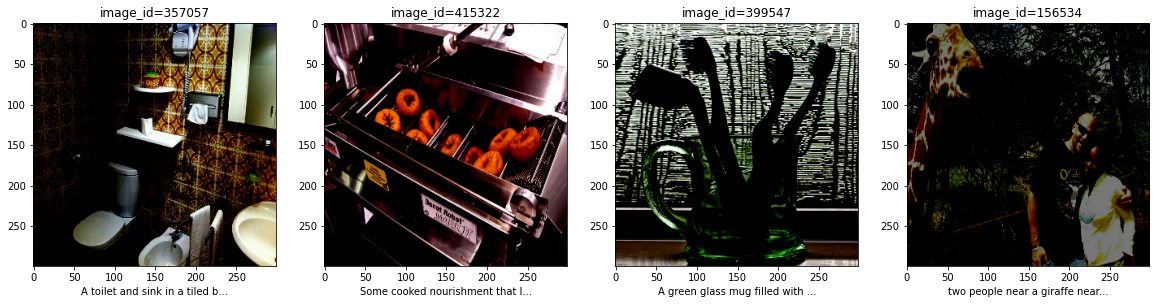

In [15]:
f, ax = plt.subplots(1, 4, figsize=(20, 5))
for idx, data in enumerate(trainds.take(4)):
  ax[idx].imshow(data['image_tensor'].numpy())
  ax[idx].set_title('image_id={}'.format(data['image_id'].numpy()))
  ax[idx].set_xlabel(data['captions'].numpy()[0].decode('utf-8')[:30] + str("..."))

## Tokenize captions

Add a start and end token to each caption.
Then send to the Keras tokenizer which will lowercase the captions
and remove punctuation etc. It will also retain only the most frequent
words.

In [5]:
# get all the captions to feed into the Tokenizer
train_captions = []
for data in trainds:
  str_captions = ["<start> {} <end>".format(
      t.decode('utf-8')) for t in data['captions'].numpy()]
  train_captions.extend(str_captions)
print(train_captions[:5])

['<start> A toilet and sink in a tiled bathroom <end>', '<start> A unisex bathroom decorated with a vintage theme.  <end>', '<start> A white toilet sitting next to a bidet toilet. <end>', '<start> A bathroom with a toilet, sink, and other bathroom items in it.  <end>', '<start> A bathroom with gold circle patterns containing a toilet, sink towel rack and shelving. <end>']


In [6]:
# Choose the most frequent words from the vocabulary
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
# pads each vector to the max_length of the captions
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
max_caption_length = len(cap_vector[0])
print("max_caption_length={}".format(max_caption_length))
print(cap_vector[0])
print([tokenizer.index_word[idx] for idx in cap_vector[0]])

max_caption_length=49
[  3   2 102  10 121   8   2 685  63   4   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0]
['<start>', 'a', 'toilet', 'and', 'sink', 'in', 'a', 'tiled', 'bathroom', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [14]:
def create_batched_ds(trainds, batchsize):
  # generator that does tokenization, padding on the caption strings
  # and yields img, caption
  def generate_image_captions():
    for data in trainds:
      captions = data['captions']
      img_tensor = data['image_tensor']
      str_captions = ["<start> {} <end>".format(
          t.decode('utf-8')) for t in captions.numpy()]
      seqs = tokenizer.texts_to_sequences(str_captions)
      # Pad each vector to the max_length of the captions
      padded = tf.keras.preprocessing.sequence.pad_sequences(
          seqs, padding='post', maxlen=max_caption_length)
      for caption in padded:
        yield img_tensor, caption # repeat image
  
  return tf.data.Dataset.from_generator(
      generate_image_captions,
      (tf.float32, tf.int32)).batch(batchsize)

for img, caption in create_batched_ds(trainds, 193).take(2):
    print(img.shape, caption.shape)
    print(caption[0])

(193, 299, 299, 3) (193, 49)
tf.Tensor(
[  3   2 102  10 121   8   2 685  63   4   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0], shape=(49,), dtype=int32)
(193, 299, 299, 3) (193, 49)
tf.Tensor(
[   3    2   51   98   11 1001    2  143   85    5    7  224    4    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0], shape=(49,), dtype=int32)


## Create Captioning Model

It consists of an image encoder, followed by a caption decoder.
The caption decoder incorporates an attention mechanism that
focuses on different parts of the input image.

In [50]:
class ImageEncoder(tf.keras.Model):
   def __init__(self, embedding_dim):
     super(ImageEncoder, self).__init__()
     inception = tf.keras.applications.InceptionV3(
         include_top=False,
         weights='imagenet'
     )
     self.model = tf.keras.Model(inception.input,
                                 inception.layers[-1].output)
     self.fc = tf.keras.layers.Dense(embedding_dim)

   def call(self, x):
     x = self.model(x)
     x = tf.reshape(x, (x.shape[0], -1, x.shape[3]))
     x = self.fc(x)
     x = tf.nn.relu(x)
     return x

class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)
    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

class CaptionDecoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(CaptionDecoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

encoder = ImageEncoder(EMBED_DIM)
decoder = CaptionDecoder(EMBED_DIM, ATTN_UNITS, VOCAB_SIZE)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Training loop

Here, we use a custom training loop because we have to add on to the decoder
input (dec_input) one word at a time.

In [9]:
loss_plot = []
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)


In [16]:
import time

EPOCHS = 20 # train longer for better results, of course
BATCH_SIZE = 16
batched_ds = create_batched_ds(trainds, BATCH_SIZE)

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    num_steps = 0

    for batch, (img_tensor, target) in enumerate(batched_ds):
      batch_loss, t_loss = train_step(img_tensor, target)
      total_loss += t_loss
      num_steps += 1

      if batch % 100 == 0:
        print ('Epoch {} Batch {} Loss {:.4f}'.format(
            epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    ckpt_manager.save()

    print ('Epoch {} Loss {:.6f} Time taken {:.1f} sec'.format(
        epoch + 1,
        total_loss/num_steps,
        time.time() - start))

Epoch 1 Batch 0 Loss 1.2425
Epoch 1 Batch 100 Loss 1.1784
Epoch 1 Batch 200 Loss 1.2038
Epoch 1 Batch 300 Loss 1.1831
Epoch 1 Batch 400 Loss 1.3054
Epoch 1 Batch 500 Loss 1.2653
Epoch 1 Batch 600 Loss 1.1761
Epoch 1 Batch 700 Loss 1.3217
Epoch 1 Batch 800 Loss 1.3347
Epoch 1 Batch 900 Loss 1.2160
Epoch 1 Batch 1000 Loss 1.4509
Epoch 1 Batch 1100 Loss 1.2090
Epoch 1 Batch 1200 Loss 1.2885
Epoch 1 Batch 1300 Loss 1.2374
Epoch 1 Batch 1400 Loss 1.2682
Epoch 1 Batch 1500 Loss 1.3615
Epoch 1 Batch 1600 Loss 1.3356
Epoch 1 Batch 1700 Loss 1.3971
Epoch 1 Batch 1800 Loss 1.2598
Epoch 1 Loss 1.258514 Time taken 501.3 sec
Epoch 2 Batch 0 Loss 1.2437
Epoch 2 Batch 100 Loss 1.1830
Epoch 2 Batch 200 Loss 1.2043
Epoch 2 Batch 300 Loss 1.1852
Epoch 2 Batch 400 Loss 1.3041
Epoch 2 Batch 500 Loss 1.2663
Epoch 2 Batch 600 Loss 1.1785
Epoch 2 Batch 700 Loss 1.3231
Epoch 2 Batch 800 Loss 1.3356
Epoch 2 Batch 900 Loss 1.2156
Epoch 2 Batch 1000 Loss 1.4490
Epoch 2 Batch 1100 Loss 1.2079
Epoch 2 Batch 1200 L

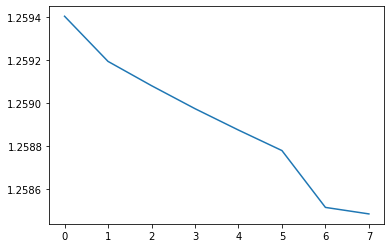

In [46]:
plt.plot(loss_plot);

## Prediction

To predict, we generate the caption one word at a time, feeding the
decoder with the previous predictions.

['wooden', 'in', 'a', 'a', 'a', 'his', 'man', 'a', 'sign', 'showing', 'the', 'at', 'left', 'batter', 'it', 'down', '<end>']


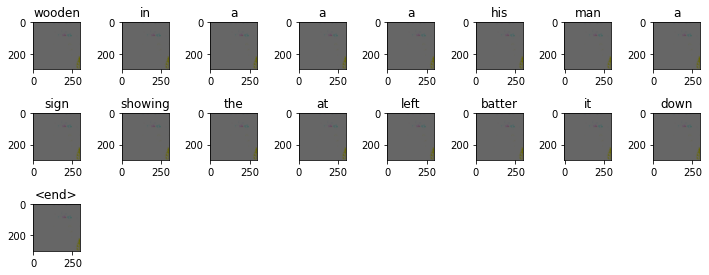

In [43]:
## Greedy prediction using the trained model
def plot_attention(image, result, attention_plot):
  fig = plt.figure(figsize=(10, 10))

  len_result = len(result)
  for l in range(len_result):
    temp_att = np.resize(attention_plot[l], (8, 8))
    ax = fig.add_subplot(len_result//2, len_result//2, l+1)
    ax.set_title(result[l])
    img = ax.imshow(image)
    ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

  plt.tight_layout()
  plt.show()

def predict_caption(filename):
  attention_plot = np.zeros((max_caption_length, ATTN_FEATURES_SHAPE))
  hidden = decoder.reset_state(batch_size=1)
  img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
  img = tf.image.resize(img, (IMG_WIDTH, IMG_HEIGHT)) # inception size
  img_tensor_val = tf.keras.applications.inception_v3.preprocess_input(img)

  features = encoder(tf.expand_dims(img_tensor_val, axis=0))
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
  result = []
  
  for i in range(max_caption_length):
    predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
    attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

    # draws from log distribution given by predictions
    predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
    result.append(tokenizer.index_word[predicted_id])
    
    if tokenizer.index_word[predicted_id] == '<end>':
      return img, result, attention_plot

    dec_input = tf.expand_dims([predicted_id], 0)
  
  attention_plot = attention_plot[:len(result), :]
  return img, result, attention_plot


filename = "gs://practical-ml-vision-book/images/bowling.jpg"
image, caption, attention_plot = predict_caption(filename)
print(caption)
plot_attention(image, caption, attention_plot)

## Plots for book

In [ ]:
print(encoder.summary())

In [ ]:
print(decoder.summary())

Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.